**Shallow to Deep Learning**

*Pattern recognition for image classification*

import pytorch modules and functions

In [ ]:
%matplotlib inline

import torch
import torch.nn as nn # neural network modules
from torch.utils.data import DataLoader # data prepreocessing modules
from torchvision import datasets # list of datasets
from torchvision.transforms import ToTensor

import numpy as np # library for math functions and linear algebra
import matplotlib.pyplot as plt # graps and plot library
import os # uses for input output such as data path
print('Using PyTorch version:', torch.__version__)

Using PyTorch version: 2.5.0+cu121


Optinal: check if you have GPU is availabe then you can set device as GPU

In [ ]:
if torch.cuda.is_available():
    print('Using GPU, device name:', torch.cuda.get_device_name(0))
    device = torch.device('cuda')
else:
    print('No GPU found, using CPU instead.')
    device = torch.device('cpu')

No GPU found, using CPU instead.


**Custom Neural Network Architecture Setting**

Let's create a neural network of input x hidden layer x output layer

This is a three layer nerual network:
*   input (img height x img width)
*   h hidden nodes with **ReLU** activation
*   k nodes at output layer correspond to k classes in img dataset

In [ ]:
class NeuralNet(nn.Module):
    def __init__(self,imgH,imgW,h1Nodes, imgCat):
        super(NeuralNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(imgH*imgW, h1Nodes),
            nn.ReLU(), # this activation function applies to hidden nodes and can vary (e.g., sigmoid, tanh)
            nn.Linear(h1Nodes, imgCat)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
def correct(output, target):
    predicted_class = output.argmax(1)                          # pick class with largest network output
    prediction = (predicted_class == target).type(torch.float)  # 1.0 for correct, 0.0 for incorrect
    return prediction.sum().item()                              # count number of correct classification/prediction

In [ ]:
def train(data_loader, model, lossfunt, optimizer):
    model.train()

    num_examples = len(data_loader.dataset)
    num_batches = len(data_loader)

    total_loss = 0
    total_correct = 0

    for data, target in data_loader:
        # Copy data and targets to GPU
        data = data.to(device)
        target = target.to(device)

        # Do a forward pass
        output = model(data)

        # Calculate the loss
        loss = lossfunt(output, target)
        total_loss += loss

        # Count number of correct digits
        total_correct += correct(output, target)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    train_loss = total_loss/num_batches
    accuracy = total_correct/num_examples
    return [train_loss, accuracy]
    #print(f"Average loss: {train_loss:7f}, accuracy: {accuracy:.2%}")

**Loading MNIST (Charecter Recognition) dataset**

In [ ]:
batch_size = 32 # batch size a hyperparamter that can be tuned
train_dataset = datasets.MNIST('../data', train=True, download=True, transform=ToTensor())
test_dataset = datasets.MNIST('../data', train=False, transform=ToTensor())

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

print('Training dataset: ',len(train_loader.dataset))
print('Test     dataset: ',len(test_loader.dataset))

Training dataset:  60000
Test     dataset:  10000


In [ ]:
print('number of training examples/images in the dataset.     : ',len(train_loader.dataset))
print('number of training examples/images in a training batrch: ',len(train_loader),' batch size', int(len(train_loader.dataset)/len(train_loader)) )

number of training examples/images in the dataset.     :  60000
number of training examples/images in a training batrch:  1875  batch size 32


Check the dataset has the correct format/tensor size

You should expect input tensor be [batch_size x img channel x img height x img weidth]

In [ ]:
for (data, target) in train_loader:
    print('data:', data.size(), 'type:', data.type())
    print('target:', target.size(), 'type:', target.type())
    break

data: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
target: torch.Size([32]) type: torch.LongTensor


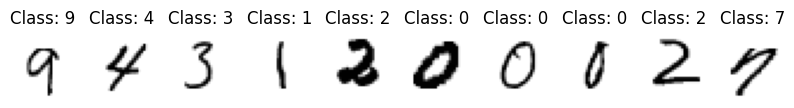

In [ ]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(data[i,:,:,:].numpy().reshape(28,28), cmap="gray_r")
    plt.title('Class: '+str(target[i].item()))

In [ ]:
print(' img Channels :',train_loader.dataset[0][0].size()[0])
print(' img Height   :',train_loader.dataset[0][0].size()[1])
print(' img Weighth  :',train_loader.dataset[0][0].size()[2])

 img Channels : 1
 img Height   : 28
 img Weighth  : 28


**Neural Networks Models Setup**

In [ ]:
# test values, these will change depending on the datasest
imgH = train_loader.dataset[0][0].size()[1] # 28    # pixels along y axis (height)
imgW =imgH   # pixels along x axis (width); in the case of square image imgW =imgH
h1Nodes = 20 # number of node in the hidden layer
imgCat = 10  # output classes

model = NeuralNet(imgH,imgW,h1Nodes, imgCat).to(device)
print(model)

NeuralNet(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=20, bias=True)
    (2): ReLU()
    (3): Linear(in_features=20, out_features=10, bias=True)
  )
)


**Main Training Loop**

In [ ]:
lossfunt = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 20

history = []
for epoch in range(epochs):
    #print(f"Training epoch: {epoch+1}")
    history.append(train(train_loader, model, lossfunt, optimizer))

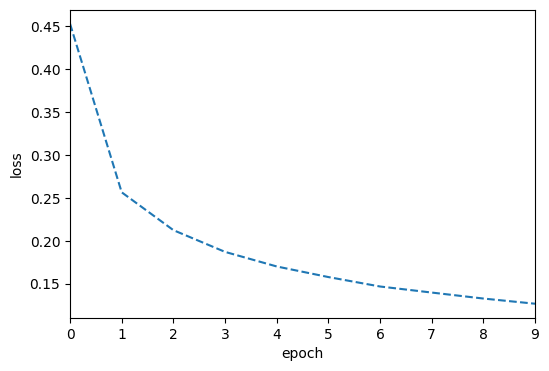

In [ ]:
#print(history)
pltsize=1
plt.figure(figsize=(6, 4))

ypoints = np.array([history[i][0].item() for i in range(len(history))])
#ypoints = np.array([history[i][1] for i in range(len(history))])

plt.plot(ypoints, linestyle = '--')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.xlim(0, 9)
plt.show()

**Model Infernce / Test**

In [ ]:
def test(test_loader, model, lossfunt):
    model.eval()

    num_examples = len(test_loader.dataset)
    num_batches = len(test_loader)

    test_loss = 0
    total_correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            # Copy data and targets to GPU
            data = data.to(device)
            target = target.to(device)

            # Do a forward pass
            output = model(data)

            # Calculate the loss
            loss = lossfunt(output, target)
            test_loss += loss.item()

            # Count number of correct digits
            total_correct += correct(output, target)

    test_loss = test_loss/num_batches
    accuracy = total_correct/num_examples

    print(f"Testset accuracy: {100*accuracy:>0.1f}%, average loss: {test_loss:>7f}")

In [ ]:
test(test_loader, model, lossfunt)

Testset accuracy: 95.6%, average loss: 0.153159
